In [2]:
import sys, os, scprep, torch, anndata, graphtools, magic, scanpy, sklearn
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
from torch import nn, optim
from sklearn import decomposition
from collections import Counter

In [2]:
sys.path.append('~/bin/AAnet/') # replace with location of AAnet
from AAnet_torch import *

### Global Setup

In [5]:
np.random.seed(0)
tissue_id = 2
N_ARCHETYPES = 3
azim = 440
tissues = ['WT', 'HFD', 'OB/OB']
usamples = ["WT", "OB/OB", "WT", "HFD"]
lut = {usamples[i]: plt.get_cmap("tab10")(i) for i in range(4)}

In [4]:
adata_beta = scanpy.read_h5ad('../data/beta_run_2.h5ad')

In [5]:
adata_beta_obob = adata_beta[adata_beta.obs['samples'] == tissues[tissue_id]]

obob_magic_op = magic.MAGIC(random_state=42, t=10)
obob_magic = obob_magic_op.fit_transform(adata_beta_obob.to_df())

Calculating MAGIC...
  Running MAGIC on 7602 cells and 16483 genes.


/home/aarthivenkat/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


  Calculating graph and diffusion operator...
    Calculating PCA...


/usr/lib/python3.8/site-packages/magic/magic.py:474: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 3.63 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.66 seconds.
    Calculating affinities...
    Calculated affinities in 4.86 seconds.
  Calculated graph and diffusion operator in 14.23 seconds.
  Running MAGIC with `solver='exact'` on 16483-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 17.88 seconds.
Calculated MAGIC in 32.26 seconds.


In [6]:
obob_pc_op = decomposition.PCA(n_components=20, random_state=42)
obob_magic_pc = obob_pc_op.fit_transform(obob_magic)
obob_magic_pc_norm = obob_magic_pc / np.std(obob_magic_pc[:, 0])

### Get extrema

In [9]:
distances, _ = sklearn.neighbors.NearestNeighbors(n_neighbors=2000).fit(obob_magic_pc_norm).kneighbors()
distances = distances.max(axis=1)
p = distances / distances.sum()
X_subsample = scprep.select.select_rows(obob_magic_pc_norm, idx=np.random.choice(obob_magic_pc_norm.shape[0],
                                                                int(obob_magic_pc_norm.shape[0]/2), p=p, replace=False))

extrema = torch.Tensor(utils.get_laplacian_extrema(X_subsample, n_extrema=N_ARCHETYPES, subsample=False))
extrema = torch.Tensor(X_subsample[extrema.numpy().astype(int)])

<class 'networkx.utils.decorators.argmap'> compilation 17:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Axes3DSubplot:title={'center':'OB/OB'}>

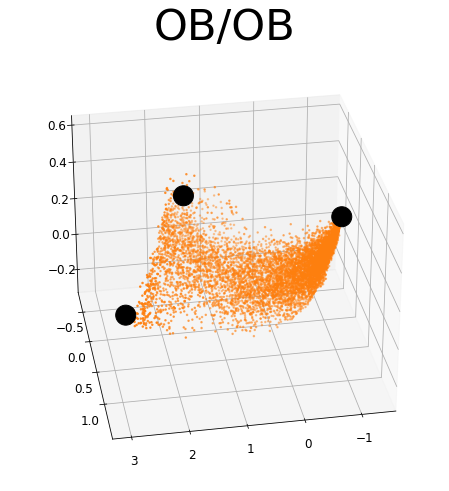

In [29]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

scprep.plot.scatter3d(obob_magic_pc_norm, c=lut[tissues[tissue_id]],
                          ylabel=None, zorder=1,
                          title=f'{tissues[tissue_id]}', fontsize=25, colorbar=False, ax=ax)

scprep.plot.scatter3d(extrema.cpu().detach().numpy(), ax=ax, azim=azim,
                             c='black', s=400, figsize=(10,10), colorbar=False, alpha=1)

### Run AAnet

In [11]:
device = torch.device('cpu')
model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES, 
                             input_shape=obob_magic_pc_norm.shape[1],
                             device=device, diffusion_extrema=extrema)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
data_loader = torch.utils.data.DataLoader(obob_magic_pc_norm, batch_size=256, shuffle=True, num_workers=4)

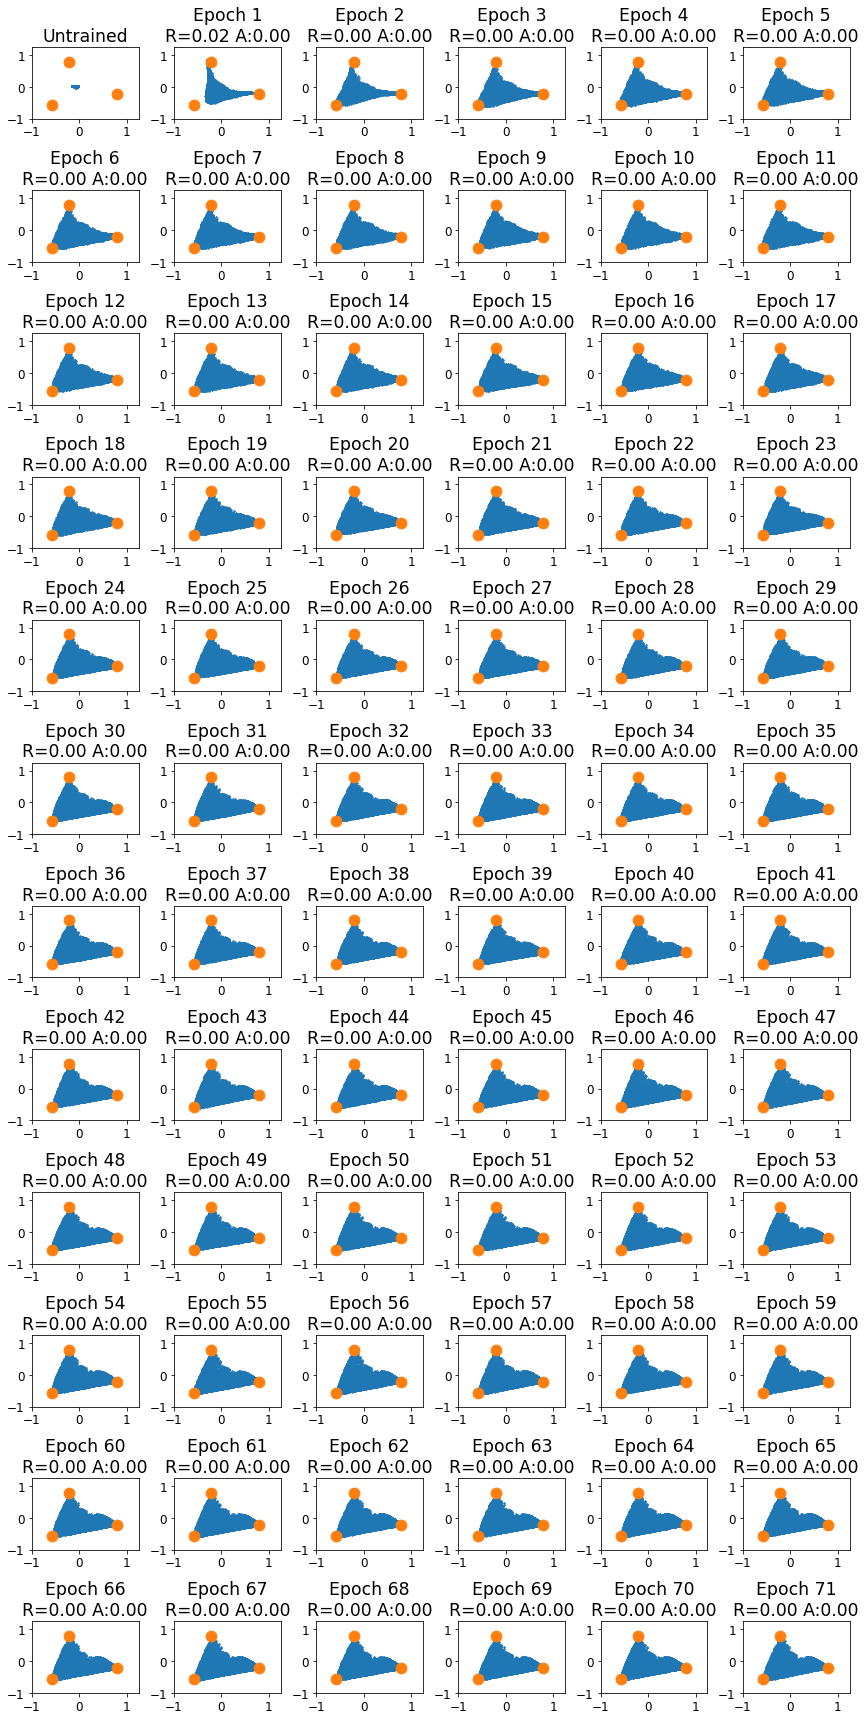

In [13]:
n_row = 12
n_col = 6
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        r_loss = a_loss = 0

        title='Untrained'
    else:
        # gamma_extrema parameter weights how informative graph-based extrema are to model
        loss, r_loss, a_loss=utils.train_epoch(model, data_loader, optimizer, epoch=i, gamma_extrema=1)
        title='Epoch {}\nR={:.2f} A:{:.2f}'.format(i, r_loss, a_loss)

    archetypal_embedding = model.encode(torch.Tensor(obob_magic_pc_norm))

    scprep.plot.scatter2d(archetypal_embedding.detach().cpu().numpy(), title=title, ax=ax)
    scprep.plot.scatter2d(model.get_n_simplex(model.n_archetypes).cpu().numpy(), ax=ax)
    ax.set_xlim(-1, 1.25)
    ax.set_ylim(-1, 1.25)

fig.tight_layout()

In [14]:
archetypal_embedding = model.encode(torch.Tensor(obob_magic_pc_norm))
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()
pc_ats = model.decode(model.get_n_simplex(model.n_archetypes).type(torch.float)).cpu().detach().numpy()

In [15]:
data_ats = ((pc_ats * np.std(obob_magic_pc[:,0])) @ obob_pc_op.components_)

In [6]:
obob_magic_pc_norm = pd.read_pickle('results/OB_OB_magic_pc_norm.pkl')
pc_ats = np.load(f'results/{tissues[tissue_id].replace("/", "_")}_pc_{N_ARCHETYPES}_ats.npy')

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(


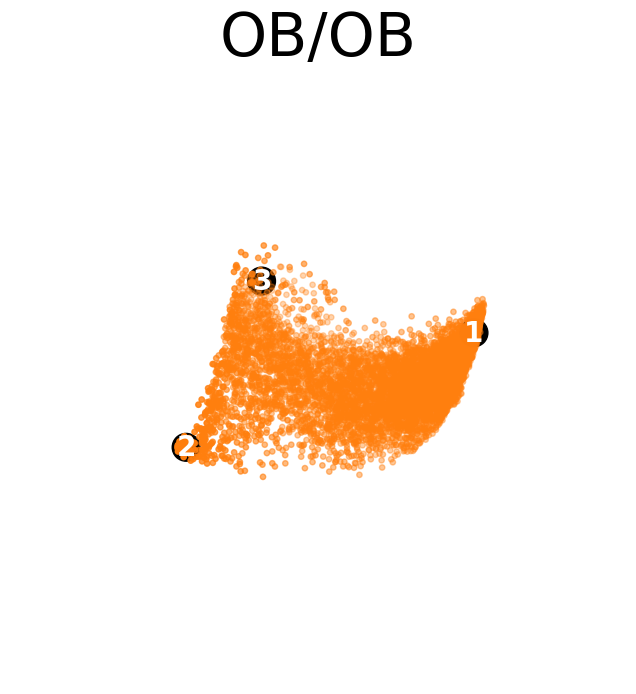

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

scprep.plot.scatter3d(obob_magic_pc_norm, c=lut[tissues[tissue_id]],
                          ylabel=None, zorder=1, s=15,
                          title=f'{tissues[tissue_id]}', fontsize=25, colorbar=False, ax=ax)

scprep.plot.scatter3d(pc_ats, ax=ax, c='black', s=400, figsize=(10,10), colorbar=False, alpha=1,  azim=azim,)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.axis('off')
for t,coord in enumerate(pc_ats):
        ax.text(coord[0], coord[1], coord[2], s=t+1, horizontalalignment='center',
                        verticalalignment='center', fontdict={'color': 'white','size':20,'weight':'bold'}, zorder=4)

In [9]:
fig.savefig(f'figures/{tissues[tissue_id].replace("/", "_")}_{N_ARCHETYPES}_ats.png', dpi=200)

### Save Model

In [35]:
torch.save(model.state_dict(), f'results/{tissues[tissue_id].replace("/", "_")}_{N_ARCHETYPES}_model_state_dict')

In [37]:
np.save(f'results/{tissues[tissue_id].replace("/", "_")}_data_{N_ARCHETYPES}_ats', data_ats)
np.save(f'results/{tissues[tissue_id].replace("/", "_")}_pc_{N_ARCHETYPES}_ats', pc_ats)
np.save(f'results/{tissues[tissue_id].replace("/", "_")}_latent_coords_{N_ARCHETYPES}_ats', barycentric_archetypal_embedding)